# Noisy Deep Q-Network (DQN) for LunarLander-v2

This notebook is an implementation of a Deep Q-Network to tackle the "LunarLander-v2" environment in OpenAI Gym. The DQN will learn to land a spacecraft safely on the lunar surface. The goal is to achieve an average score of 195 or above over the last 50 episodes.

### Import Libraries

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import os
import renderlab
import itertools
from torch.nn.init import uniform_
import math

### Define the Hyperparameters & Variables

Setting up hyperparameters like learning rate, batch size, exploration rates, and defining the file path for saving the trained Noisy DQN model.

In [2]:
# Define the Parameters

# Discount factor for future rewards
GAMMA = 0.99  
# Size of the batch used in learning
BATCH_SIZE = 128 
# Maximum size of the replay buffer
BUFFER_SIZE = 10000  
# Starting value of epsilon for the epsilon-greedy policy
EPS_START = 1.0 
# Minimum value of epsilon for the epsilon-greedy policy
EPS_END = 0.01
# Decay rate of epsilon per episode
EPS_DECAY = 0.995  
# Learning rate for the neural network optimizer
LEARNING_RATE = 0.0005  

# Define the Variables

# Threshold score for considering the environment solved
solved_score = 195
# List to keep track of total reward per episode
scores = []  
# List to keep track of average score over the last 50 episodes
average_scores = []  
# Maximum steps per episode to prevent very long episodes
max_steps_per_episode = 2000 
# Flag to indicate whether the environment is solved
solved = False 

In [3]:
# Define the path where the trained model will be saved
model_save_path = 'models/noisy_dqn_lunarlander_model.pth'

# Extract the directory path from the model save path
model_directory = os.path.dirname(model_save_path)
# Check if the directory exists
if not os.path.exists(model_directory):
    # If the directory does not exist, create it
    os.makedirs(model_directory)
    
# Define the path for saving average score data
folder_path = 'average_scores/'

# Check if the directory for average scores exists
if not os.path.exists(folder_path):
    # If the directory does not exist, create it
    os.makedirs(folder_path)

### Noisy Linear Layer Implementation


In [4]:
class NoisyLinear(nn.Module):
    def __init__(self, in_size, out_size):
        super(NoisyLinear, self).__init__()

        # Initialize the mean (mu) and standard deviation (sigma) for the weights
        self.w_mu = nn.Parameter(torch.empty((out_size, in_size)))
        self.w_sigma = nn.Parameter(torch.empty((out_size, in_size)))

        # Initialize the mean (mu) and standard deviation (sigma) for the biases
        self.b_mu = nn.Parameter(torch.empty((out_size)))
        self.b_sigma = nn.Parameter(torch.empty((out_size)))

        # Uniformly initialize the mean parameters
        uniform_(self.w_mu, -math.sqrt(3 / in_size), math.sqrt(3 / in_size))
        uniform_(self.b_mu, -math.sqrt(3 / in_size), math.sqrt(3 / in_size))

        # Initialize the sigma parameters with a constant value
        nn.init.constant_(self.w_sigma, 0.017)
        nn.init.constant_(self.b_sigma, 0.017)

    def forward(self, x, sigma=1):
        # During training, add noise to the weights and biases
        if self.training:
            # Generate random noise for weights and biases
            w_noise = torch.normal(0, sigma, size=self.w_mu.size())
            b_noise = torch.normal(0, sigma, size=self.b_mu.size())

            # Apply noisy linear transformation
            return F.linear(x, self.w_mu + self.w_sigma * w_noise, self.b_mu + self.b_sigma * b_noise)
        else:
            # During evaluation, use the mean values without noise
            return F.linear(x, self.w_mu, self.b_mu)

### Noisy DQN Model

Below is the neural network that will approximate the Q-value function. The network will take the state as input and output Q-values for each action.

In [5]:
class NOISY_DQN(nn.Module):
    # The constructor of the NOISY_DQN class, inheriting from nn.Module
    def __init__(self, state_size, action_size):
        super(NOISY_DQN, self).__init__()
        # Initialize the first fully connected layer with noise
        self.fc1 = NoisyLinear(state_size, 64)
        # Initialize the second fully connected layer with noise
        self.fc2 = NoisyLinear(64, 64)
        # Initialize the third fully connected layer with noise
        # This layer outputs Q-values for each action
        self.fc3 = NoisyLinear(64, action_size)

    def forward(self, x):
        # Pass input through the first noisy linear layer and apply ReLU activation
        x = F.relu(self.fc1(x))
        # Pass through the second noisy linear layer and apply ReLU activation
        x = F.relu(self.fc2(x))
        # Pass through the final noisy linear layer to get Q-values for each action
        return self.fc3(x)

### Replay Memory

Using a replay memory to store transitions that the agent observes, allowing to reuse this data later. This helps in breaking the correlation between consecutive learning samples.

In [6]:
# Define a namedtuple to store the experience tuples
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:
    # Constructor for ReplayMemory class
    def __init__(self, capacity):
        # Initialize a double-ended queue with a fixed maximum size (capacity)
        # This deque will store the transitions
        self.memory = deque([], maxlen=capacity)

    # Method to push a new transition into the memory
    def push(self, *args):
        self.memory.append(Transition(*args))

    # Method to randomly sample a batch of transitions from the memory
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    # Method to return the length of the memory
    def __len__(self):
        return len(self.memory)

### DQN Agent Class

Encapsulating the learning mechanisms of the DQN agent, including action selection, model optimization, and interaction with the replay memory, along with managing the exploration rate decay.

In [7]:
class Noisy_DQNAgent:
    # Constructor for the noisy DQN agent
    def __init__(self, state_size, action_size):
        # Store state and action sizes for later use
        self.state_size = state_size  
        self.action_size = action_size  
        
        # Initialize epsilon (although not directly used in action selection for Noisy DQN)
        self.epsilon = EPS_START  

        # Create the Noisy DQN models for policy and target networks
        self.policy_net = NOISY_DQN(state_size, action_size)
        self.target_net = NOISY_DQN(state_size, action_size)
        # Initialize the target network with weights from the policy network
        self.target_net.load_state_dict(self.policy_net.state_dict())
        # Set the target network to evaluation mode (not training)
        self.target_net.eval()

        # Setup the optimizer for the policy network
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LEARNING_RATE)
        # Initialize the replay memory buffer
        self.memory = ReplayMemory(BUFFER_SIZE)

    # Method to perform optimization on the policy network
    def optimize_model(self):
        # Return if insufficient data in replay memory
        if len(self.memory) < BATCH_SIZE:
            return

        # Sample a batch of experiences from memory
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        # Mask for filtering non-final states
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
        # Collect non-final next states
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        # Batch the various components of transitions
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, dtype=torch.float32)

        # Compute current Q values using policy network
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        # Initialize next Q values to zero and update for non-final states
        next_state_values = torch.zeros(BATCH_SIZE)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
        # Calculate expected Q values
        expected_state_action_values = (next_state_values * GAMMA) * (1 - done_batch) + reward_batch

        # Compute loss and backpropagate
        loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()  # Clear existing gradients
        loss.backward()  # Compute gradients
        self.optimizer.step()  # Update network weights

    # Method to update the weights of the target network
    def update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    # Method to select an action based on current state without exploration noise (Noisy DQN handles exploration internally)
    def select_action(self, state):
        with torch.no_grad():  # Disable gradient calculation
            return self.policy_net(state).max(1)[1].view(1, 1)  # Choose action with highest Q-value

### Training Loop

Runs the LunarLander-v2 environment for a set number of episodes, gathering experiences and optimizing the agent's policy network based on these experiences.

In [8]:
# Initialize the Lunar Lander environment
env = gym.make('LunarLander-v2')
# Get the size of the state space from the environment
state_size = env.observation_space.shape[0]  
# Get the number of actions available from the environment
action_size = env.action_space.n  

# Instantiate a Noisy DQN agent with state and action sizes
agent = Noisy_DQNAgent(state_size, action_size)

# Training loop
for i_episode in itertools.count():  # Loop over episodes indefinitely
    # Reset the environment and get the initial state
    state_tuple = env.reset()
    state = state_tuple[0] if isinstance(state_tuple, tuple) else state_tuple
    # Convert state to tensor for neural network input
    state = torch.from_numpy(state).float().unsqueeze(0)
    # Initialize variables for tracking rewards and steps
    total_reward = 0
    done = False
    step_count = 0  # Counter for steps in the episode

    # Loop until the episode is done or maximum steps are reached
    while not done and step_count < max_steps_per_episode:
        # Select action based on current state
        action = agent.select_action(state)
        # Execute the action in the environment and observe next state, reward, and done flag
        output = env.step(action.item())
        next_state = output[0]
        reward = output[1]
        done = output[2]

        # Convert next state to tensor
        next_state = torch.from_numpy(next_state).float().unsqueeze(0)
        # Convert reward to tensor
        reward_tensor = torch.tensor([reward], dtype=torch.float)

        # Store the experience in replay memory
        agent.memory.push(state, action, next_state, reward_tensor, done)
        # Update the state for the next iteration
        state = next_state
        # Accumulate reward
        total_reward += reward
        # Optimize the model
        agent.optimize_model()

        # Increment step count
        step_count += 1

    # Update the target network weights
    agent.update_target_net()
    # Append the total reward of this episode to the scores list
    scores.append(total_reward)

    # Check for solving condition (average score over last 50 episodes)
    if len(scores) >= 50:
        avg_score_last_50 = np.mean(scores[-50:])
        average_scores.append(avg_score_last_50)
        if avg_score_last_50 >= solved_score and not solved:
            print("*"*125)
            print(f"Solved at episode: {i_episode} - Average score over the last 50 episodes: {avg_score_last_50}")
            # Save the trained model
            torch.save(agent.policy_net.state_dict(), model_save_path)
            print("*"*125)
            print(f"Model successfully saved to {model_save_path}")
            solved = True
            break  # Exit the loop as the environment is solved

    # Output progress every 10 episodes
    if i_episode % 10 == 0:
        avg_score_last_10 = np.mean(scores[-10:]) if len(scores) >= 10 else np.mean(scores)
        print(f"Episode {i_episode}, Average Score Last 10 Episodes: {avg_score_last_10}")

# Save the average scores for later analysis
np.save(folder_path + 'average_scores_noisy.npy', average_scores)  

# Close the environment
env.close()

Episode 0, Average Score Last 10 Episodes: -118.22450592349477
Episode 10, Average Score Last 10 Episodes: -177.06644063279015
Episode 20, Average Score Last 10 Episodes: -150.9244493360728
Episode 30, Average Score Last 10 Episodes: -245.76233128643784
Episode 40, Average Score Last 10 Episodes: -165.9362466278957
Solved at episode: 49 - Average score over the last 50 episodes: -180.81890940702488
Model successfully saved to models/noisy_dqn_lunarlander_model.pth


### Training Progress Visualization

Visualizing the training progress with a plot of the average reward per episode (Y-axis) against the number of episodes (X-axis).

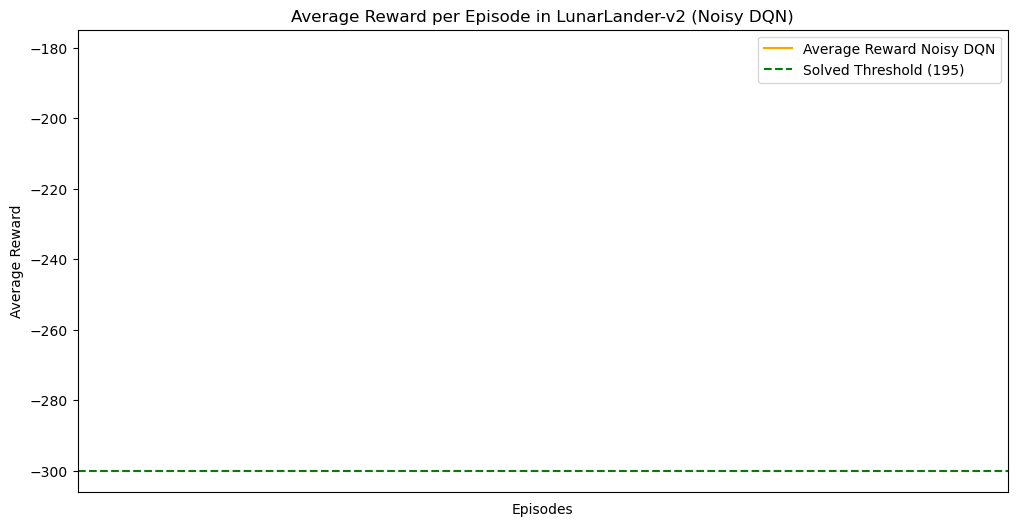

In [9]:
# Creating the plot

# Generate a range of episode numbers for the x-axis
# Start from episode 10 and increment by 10 until the number of episodes recorded
episode_numbers = list(range(10, len(average_scores) * 10 + 1, 10))

plt.figure(figsize=(12, 6))

# Plot average rewards per episode
plt.plot(episode_numbers, average_scores, label='Average Reward Noisy DQN', color='orange')

# Add a horizontal line representing the solved threshold
plt.axhline(y=solved_score, color='green', linestyle='--', label='Solved Threshold (195)')

# Set x-axis labels to show every 100 episodes
plt.xticks(range(0, len(average_scores) + 1, 100))

# Set labels for x and y axes
plt.xlabel('Episodes')
plt.ylabel('Average Reward')

# Display the plot
plt.title('Average Reward per Episode in LunarLander-v2 (Noisy DQN)')
plt.legend()
plt.show()

In [10]:
## Initialize the environment
#env = gym.make('LunarLander-v2', render_mode='rgb_array')
#
## Wrap the environment with RenderFrame from renderlab to record video
#env = renderlab.RenderFrame(env, "./video")
#
## Initialize your DQN agent here
#state_size = env.observation_space.shape[0]
#action_size = env.action_space.n
#agent = Noisy_DQNAgent(state_size, action_size)
#agent.policy_net.load_state_dict(torch.load(model_save_path))
#
## Reset the environment and get the initial observation
#obs, info = env.reset()
#
#while True:
#    # Convert the observation to a tensor and pass it to the agent to select an action
#    obs_tensor = torch.from_numpy(obs).float().unsqueeze(0)
#    action = agent.select_action(obs_tensor).item()
#
#    # Take the action in the environment
#    obs, reward, terminated, truncated, info = env.step(action)
#
#    # Check if the episode is done
#    if terminated or truncated:
#        break
#
## Play the recorded video
#env.play()